In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import EfficientNetB7
from keras.callbacks import ReduceLROnPlateau
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import keras
import random

ModuleNotFoundError: No module named 'pandas'

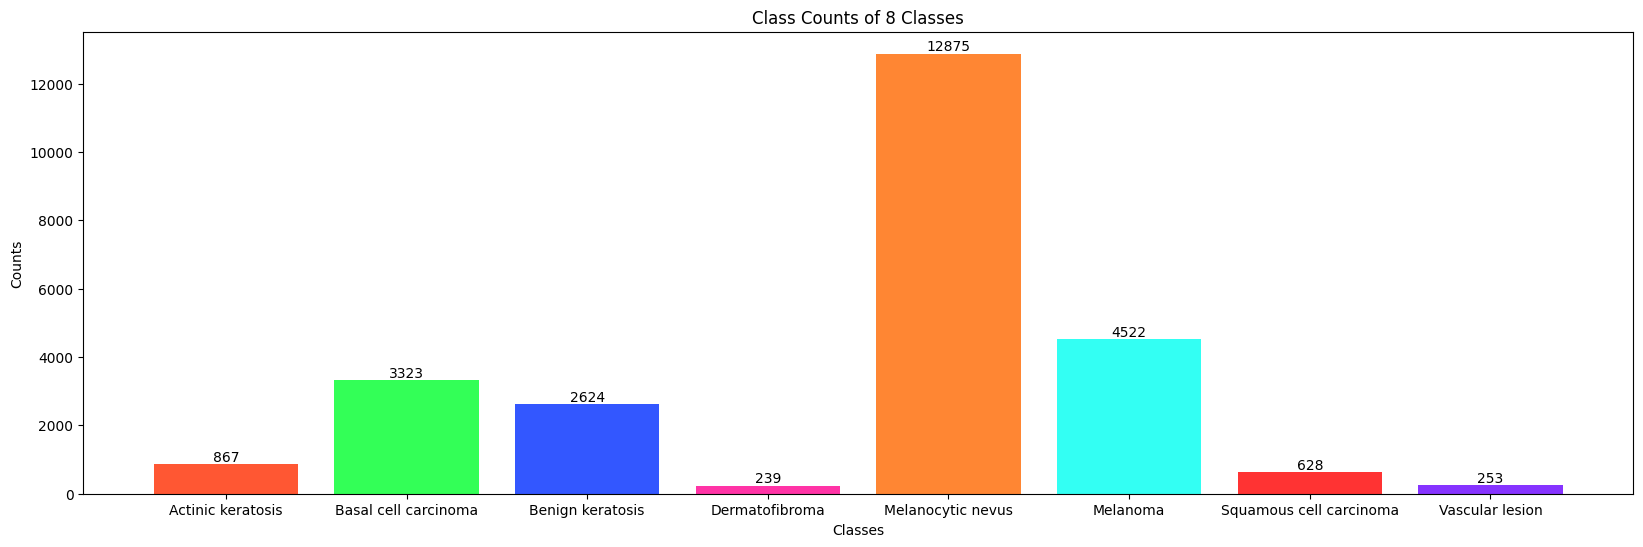

In [9]:
''' Block to visualize class frequencies before oversampling and undersampling '''
data_path = 'data\ISIC_Labelled'
classes = os.listdir(data_path) # names of folders are the names of classes
class_counts = [len(os.listdir(data_path + '/' + x)) for x in classes] # length of respective classes is the count of images available for the respective class
#print(class_counts)
plt.figure(figsize=(20, 6))
bars = plt.bar(classes, class_counts, color = ['#FF5733', '#33FF57', '#3357FF', '#FF33A6', '#FF8633', '#33FFF3', '#FF3333', '#8633FF']) # 8 random colors chosen for better visualisation
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
# Code to display count of each class on top of respective bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height, 
        f'{height}', 
        ha='center', 
        va='bottom'
    )

# Issue of class imbalance
As seen from the bar graph samples for classes like Dermatofibroma, Vascular lesion, Actinic Keratosis and Squamous cell carcinoma are less then 1000 while the remaining four classes have samples above 1000 and for Melanocytic nevus it is too high at 9012. The issue is generally called class imbalance problem which causes the training to be biased to the majority class inturn reducing accuracy of model. The issue can be solved by the following two techniques:
<ul>
<li> Undersampling </li>
<li> Oversampling </li>
</ul>
<ul>
<li> Undersampling brings down the samples of majority classes by just trimming out the datasets. Disadvantage: Information lost can lead to underfitting. </li>
<li> Oversampling increases samples by replicating images available in many ways. Disavantage: It can lead to overfitting over same sample if not done correctly </li>
</ul>
For this dataset either oversampling or undersampling alone will not work as the huge difference between the counts will either bring overfitting or underfitting problem. Combination of both the techniques is to be used. 
<p> First oversampler is used for all the 7 classes to increase the count to 5000. The oversampler function is coded to use rndom image from the available images every time till the required count is achieved. Random image is chosen so as to prevent overfitting on single image duplicates. </p>

In [22]:
def oversampler(class_name, class_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    curr_dir = data_path + '/' + class_name
    save_dir = curr_dir
    images = os.listdir(curr_dir)
    img = plt.imread(curr_dir + '/' + random.choice(images))
    img = np.expand_dims(img, 0)
    

    cnt = class_count
    target = 4000
    for batch in datagen.flow(img, batch_size=1, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
        cnt += 1
        if cnt >= target:
            break
        img = plt.imread(curr_dir + '/' + random.choice(images))
        img = np.expand_dims(img, 0)
        

def undersampler(class_name, class_count):
    target_count = 4000
    curr_dir = data_path + '/' + class_name
    images = os.listdir(curr_dir)
    images_to_delete = random.sample(images, class_count - target_count)
    for image in images_to_delete:
        img_path = os.path.join(curr_dir, image)
        os.remove(img_path)

In [37]:
for i in range(len(classes)):
    if class_counts[i] < 4000:
        oversampler(classes[i], class_counts[i])
    else:
        undersampler(classes[i], class_counts[i])

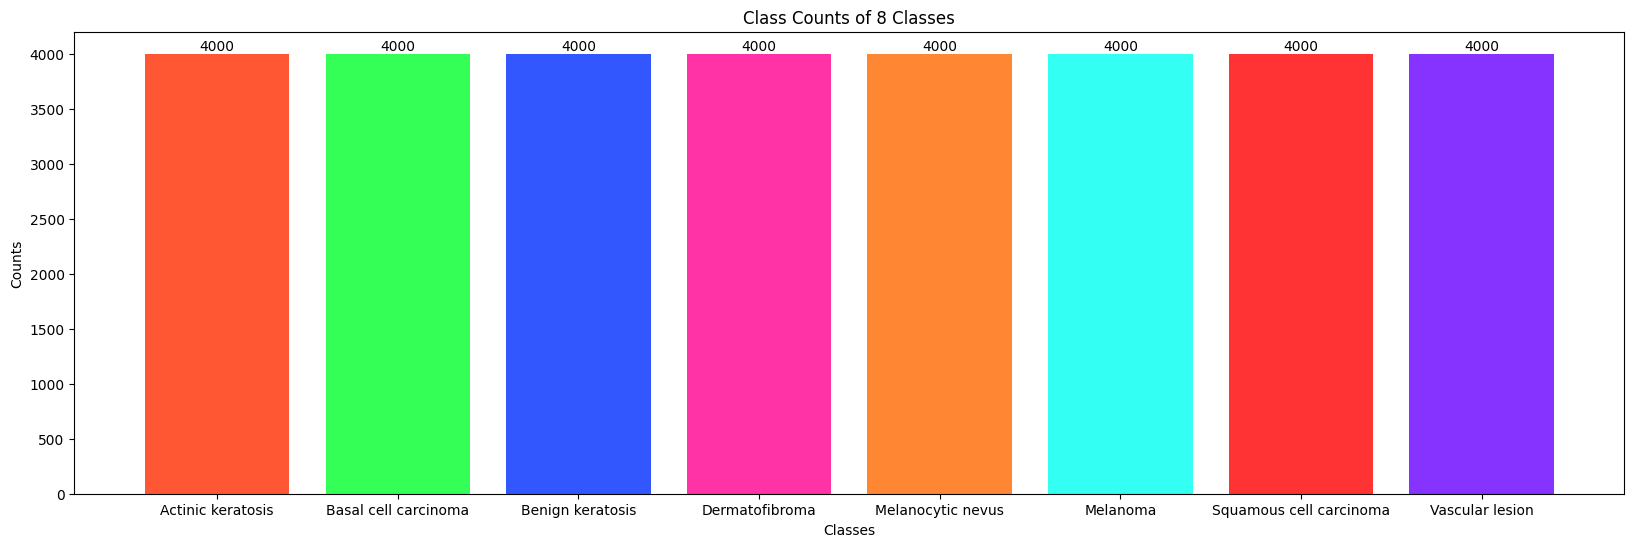

In [38]:
''' Block to visualize class frequencies after oversampling and undersampling '''
data_path = 'data\ISIC_Labelled'
classes = os.listdir(data_path) # names of folders are the names of classes
class_counts = [len(os.listdir(data_path + '/' + x)) for x in classes] # length of respective classes is the count of images available for the respective class
#print(class_counts)
plt.figure(figsize=(20, 6))
bars = plt.bar(classes, class_counts, color = ['#FF5733', '#33FF57', '#3357FF', '#FF33A6', '#FF8633', '#33FFF3', '#FF3333', '#8633FF']) # 8 random colors chosen for better visualisation
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
# Code to display count of each class on top of respective bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height, 
        f'{height}', 
        ha='center', 
        va='bottom'
    )

In [43]:
import random
import shutil

train_path = "train"
val_path = "val"
test_path = "test"

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    
    train_class_path = os.path.join(train_path, class_folder)
    val_class_path = os.path.join(val_path, class_folder)
    test_class_path = os.path.join(test_path, class_folder)
    
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)   
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val
    
    train_images = images[:num_train]
    val_images = images[num_train:num_train+num_val]
    test_images = images[num_train+num_val:]
    
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))
    
    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_class_path, image))
    
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("Dataset split completed successfully.")

data\ISIC_Labelled\Actinic keratosis
data\ISIC_Labelled\Basal cell carcinoma
data\ISIC_Labelled\Benign keratosis
data\ISIC_Labelled\Dermatofibroma
data\ISIC_Labelled\Melanocytic nevus
data\ISIC_Labelled\Melanoma
data\ISIC_Labelled\Squamous cell carcinoma
data\ISIC_Labelled\Vascular lesion
Dataset split completed successfully.


In [51]:
val_path = "val"
train_path = "train"
img_size =(256,256)
batch_size = 32
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=123
)
class_names = train_dataset.class_names
val_dataset = image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)

Found 28225 files belonging to 9 classes.
Found 8326 files belonging to 9 classes.


(32, 256, 256, 3)
[1 1 7 0 1 7 6 1 3 0 6 7 5 2 2 5 5 5 7 3 3 6 2 0 4 6 2 6 7 3 5 2]


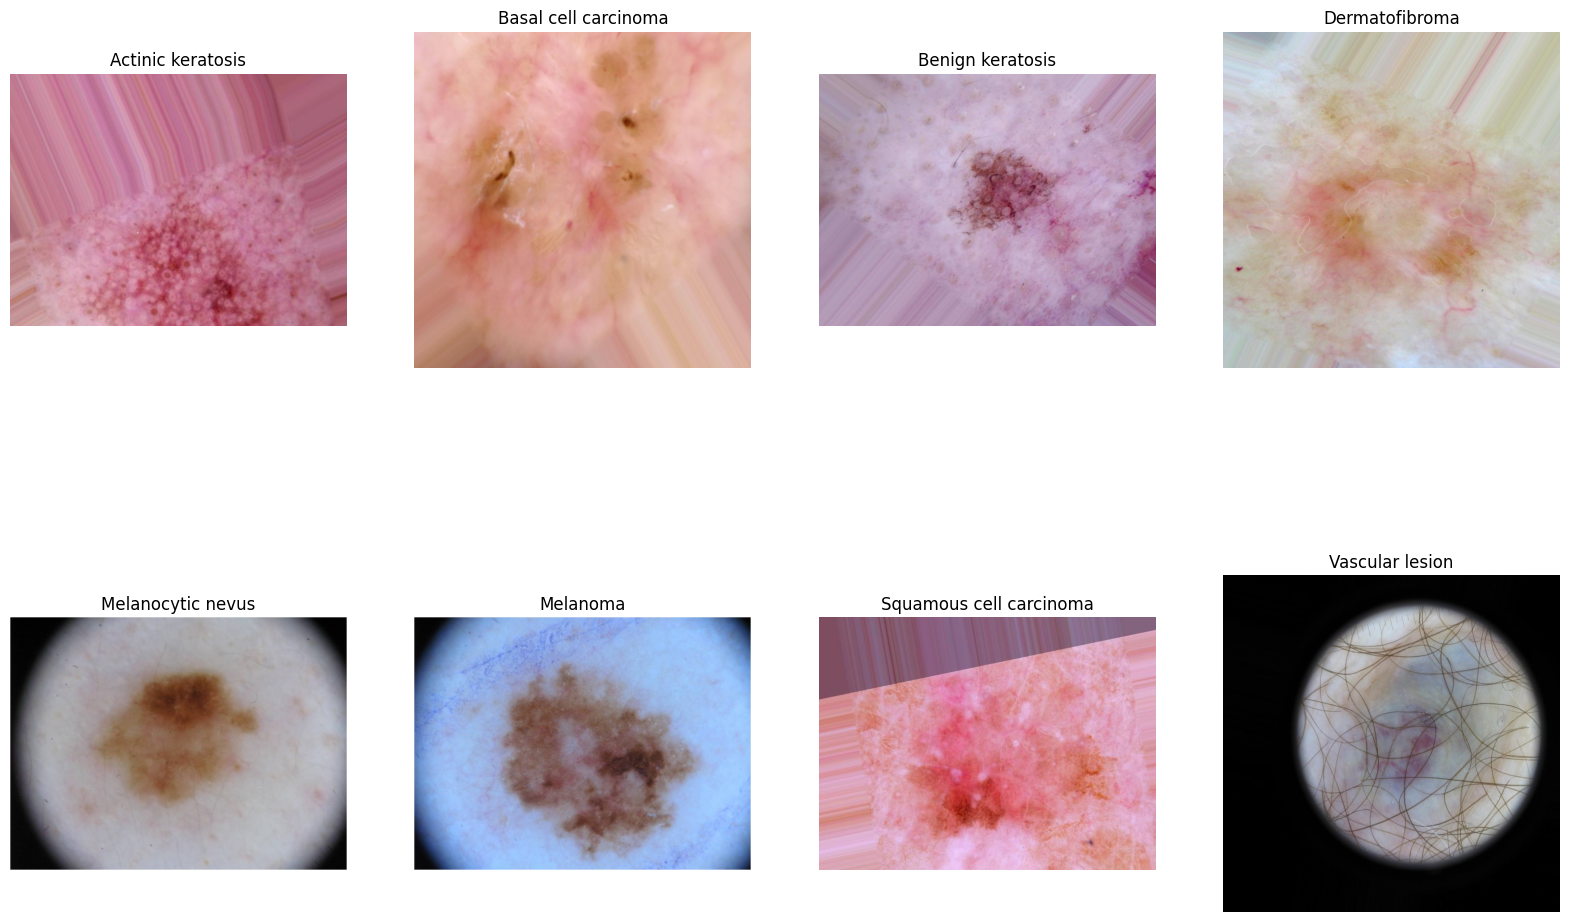

In [54]:
for image_batch, labels_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
plt.figure(figsize=(20, 20))
from PIL import Image
i = 0
for image_class in os.listdir(train_path):
    class_path = os.path.join(train_path, image_class)
    image_file = os.listdir(class_path)[0]
    image_path = os.path.join(class_path, image_file)
    image = Image.open(image_path)
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    plt.title(image_class)
    plt.axis("off")
    i += 1

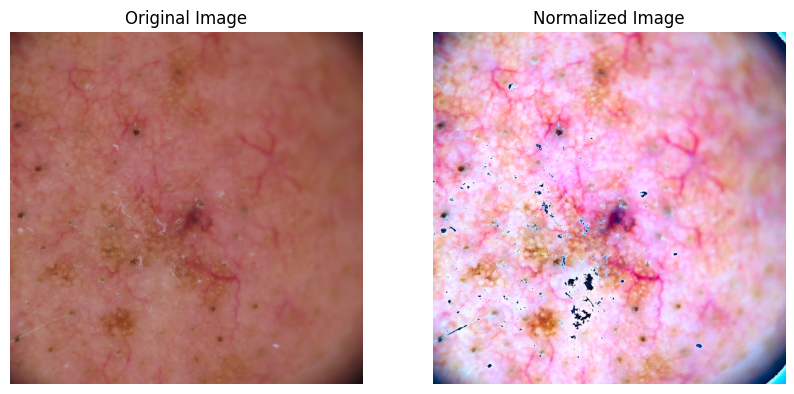

In [60]:
import numpy as np
import cv2

def stain_normalization(image, target_mean=np.array([196, 154, 122]), target_std=np.array([33, 11, 13])):
    # Convert image to LAB color space
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Compute mean and standard deviation of each channel
    image_mean = np.mean(image_lab, axis=(0, 1))
    image_std = np.std(image_lab, axis=(0, 1))
    
    # Perform stain normalization
    image_lab[:, :, 0] = (image_lab[:, :, 0] - image_mean[0]) * (target_std[0] / image_std[0]) + target_mean[0]
    image_lab[:, :, 1] = (image_lab[:, :, 1] - image_mean[1]) * (target_std[1] / image_std[1]) + target_mean[1]
    image_lab[:, :, 2] = (image_lab[:, :, 2] - image_mean[2]) * (target_std[2] / image_std[2]) + target_mean[2]
    
    # Convert back to RGB color space
    normalized_image = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    
    return normalized_image

# Example usage
input_image = cv2.imread('D:\\train\\Actinic keratosis\\ISIC_0070200.jpg')
#print(input_image)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
normalized_image = stain_normalization(input_image)

# Display original and normalized images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(normalized_image)
plt.title('Normalized Image')
plt.axis('off')

plt.show()


In [61]:
from keras.applications.efficientnet import preprocess_input

def preprocess_image(image_path, img_size=(256, 256)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    normalized_image = stain_normalization(image)

    resized_image = cv2.resize(normalized_image, img_size)
 
    preprocessed_image = preprocess_input(resized_image)
    
    return preprocessed_image

val_path = "val"
train_path = "train"



# Feature extractor
base_model = keras.applications.EfficientNetB3(
    input_shape=(256, 256, 3), 
    include_top=False,             
    weights='imagenet',
    pooling='max'
) 

for layer in base_model.layers:
    layer.trainable = False

# Build model
inputs = base_model.input
x = BatchNormalization()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(8, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
ep = 50
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=ep)

# Save model
model.save('SkinDiseaseWeightsPre1.h5')


Epoch 1/50
883/883 [==============================] - 224s 239ms/step - loss: 0.7117 - accuracy: 0.7426 - val_loss: 0.6309 - val_accuracy: 0.7710
Epoch 2/50
883/883 [==============================] - 214s 242ms/step - loss: 0.5989 - accuracy: 0.7797 - val_loss: 0.5296 - val_accuracy: 0.8075
Epoch 3/50
883/883 [==============================] - 214s 242ms/step - loss: 0.5585 - accuracy: 0.7965 - val_loss: 0.5239 - val_accuracy: 0.8053
Epoch 4/50
883/883 [==============================] - 214s 242ms/step - loss: 0.5208 - accuracy: 0.8072 - val_loss: 0.4601 - val_accuracy: 0.8344
Epoch 5/50
883/883 [==============================] - 214s 242ms/step - loss: 0.4833 - accuracy: 0.8239 - val_loss: 0.4225 - val_accuracy: 0.8447
Epoch 6/50
883/883 [==============================] - 214s 242ms/step - loss: 0.4644 - accuracy: 0.8303 - val_loss: 0.3981 - val_accuracy: 0.8589
Epoch 7/50
883/883 [==============================] - 214s 242ms/step - loss: 0.4234 - accuracy: 0.8414 - val_loss: 0.3710 -

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [67]:
import h5py

def safe_model_save(model, filepath):
    try:
        model.save(filepath)
    except Exception as e:
        print("Error saving model:", e)
        if isinstance(e, TypeError) and 'EagerTensor' in str(e):
            print("Attempting to convert problematic tensors to numpy arrays")
            for layer in model.layers:
                if hasattr(layer, 'get_weights'):
                    weights = layer.get_weights()
                    new_weights = [w.numpy() if isinstance(w, tf.Tensor) else w for w in weights]
                    layer.set_weights(new_weights)
            model.save(filepath)

safe_model_save(model, 'SkinDiseaseWeightsPre1.h5')

Error saving model: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
Attempting to convert problematic tensors to numpy arrays


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [64]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import tensorflow as tf

test_path = 'test'

test_dataset = image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)

labels = []
predictions = []
for x,y in test_dataset:
    labels.append(list(y.numpy().astype("uint8")))
    predictions.append(tf.argmax(model.predict(preprocess_input(x)),1).numpy().astype("uint8"))
import itertools
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))
print('F1 score:', f1_score(labels, predictions, average='micro'))

Found 8365 files belonging to 8 classes.
1/1 [==============================] - 2s 2s/step
Train Accuracy  : 96.52 %
Test Accuracy   : 95.27 %
Precision Score : 95.27 %
Recall Score    : 95.27 %
F1 score: 0.9526598924088464


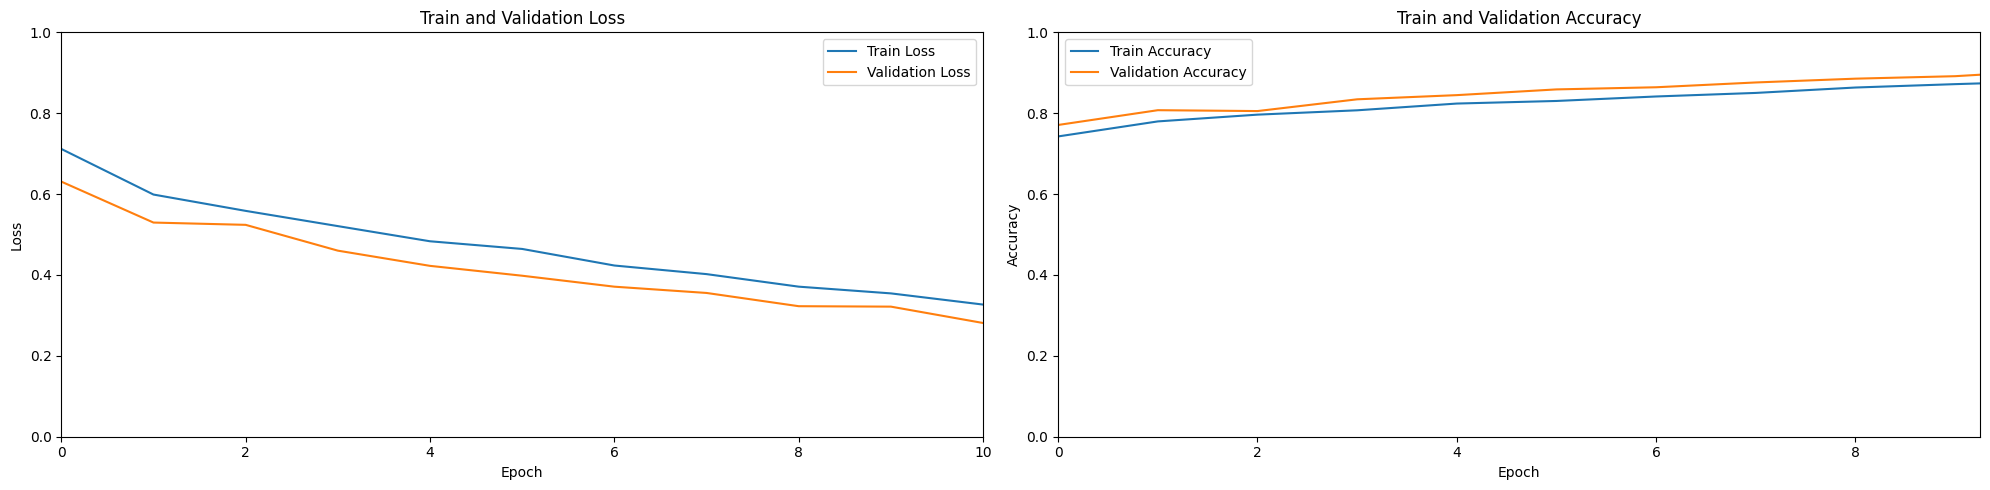

In [65]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.0,1.0)
plt.legend()
plt.tight_layout()

<Figure size 2000x500 with 0 Axes>

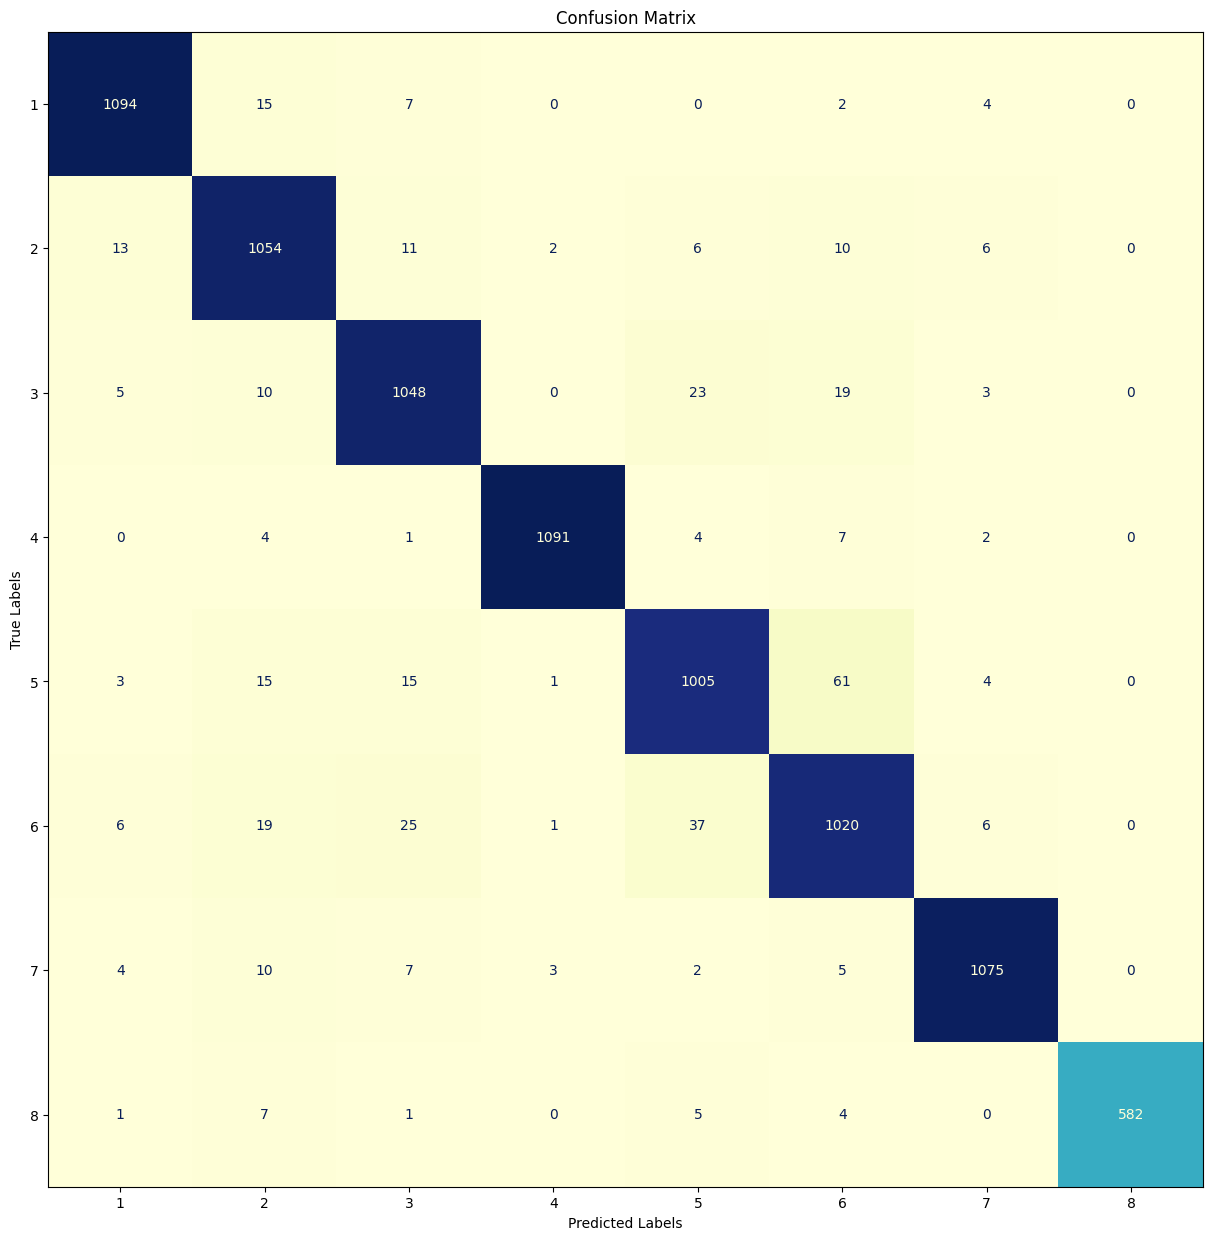

In [66]:
import sklearn
plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1,9)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()